In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


years = [2017,2018,2019] #years to consider
months = [i for i in range(1,13)]
raw_data_directory = './data/'
top_n_stations = 300 #number of stations to keep

col_names = ['trip_duration',
             'start_time',
             'stop_time',
             'start_id',
             'end_id',
             'start_lat',
             'end_lat',
             'start_long',
             'end_long']

# PASS THROUGH ALL DATA ONCE TO GET STATIONS THAT ARE PRESENT THROUGHOUT

all_counts = None
persistent_ids = set()

for year in years:
    for month in months:

        file_name = f'{year}{month:02d}-citibike-tripdata.csv'
        df = pd.read_csv(raw_data_directory+file_name)
        
        col_name_mapper = {}

        for col in df.columns:

            string = col.lower()

            if 'trip' in string and 'duration' in string:
                col_name_mapper['trip_duration'] = col
            elif 'start' in string and 'time' in string:
                col_name_mapper['start_time'] = col
            elif 'stop' in string and 'time' in string:
                col_name_mapper['stop_time'] = col
            elif 'start' in string and 'station' in string and 'id' in string:
                col_name_mapper['start_id'] = col
            elif 'end' in string and 'station' in string and 'id' in string:
                col_name_mapper['end_id'] = col
            elif 'start' in string and 'station' in string and 'latitude' in string:
                col_name_mapper['start_lat'] = col
            elif 'end' in string and 'station' in string and 'latitude' in string:
                col_name_mapper['end_lat'] = col
            elif 'start' in string and 'station' in string and 'longitude' in string:
                col_name_mapper['start_long'] = col
            elif 'end' in string and 'station' in string and 'longitude' in string:
                col_name_mapper['end_long'] = col


        col_name_mapper = dict(zip(list(col_name_mapper.values()),list(col_name_mapper.keys())))

        df = df.rename(columns=col_name_mapper)
        df = df[col_names]
        
        df = df.dropna() # drop rows where any of the desired cols are missing
        
        counts = df['start_id'].value_counts()
        
        if all_counts is None:
            all_counts = counts
            persistent_ids = set(counts.index)
        else:
            all_counts = all_counts.add(counts, fill_value=0)
            persistent_ids = persistent_ids.intersection(set(counts.index))

del df


In [ ]:
persistent_counts = all_counts[list(persistent_ids)].sort_values(ascending=False)
popular_stations = persistent_counts[:top_n_stations]['start_id'].values

plt.hist(persistent_counts['total_counts'],label='all')
plt.hist(persistent_counts[:top_n_stations]['total_counts'],label='kept')

print("Included stations = ", popular_stations)
print("Minimum number of trips = ", persistent_counts.loc[top_n_stations-1]['total_counts'])

station_id_dict = dict(zip(popular_stations,np.arange(popular_stations.shape[0])))

In [2]:
START_REF_TIME = pd.to_datetime(f'{years[0]}-{months[0]:02d}-01')


# MERGE ALL DATA INTO ONE BIG DATAFRAME; NOT THE BEST WAY TO DO THIS IF YOU HAVE LESS THAN 10GB of RAM

all_df = None

for year in years:
    for month in months:

        file_name = f'{year}{month:02d}-citibike-tripdata.csv'
        df = pd.read_csv(raw_data_directory+file_name)
        
        col_name_mapper = {}

        for col in df.columns:

            string = col.lower()

            if 'trip' in string and 'duration' in string:
                col_name_mapper['trip_duration'] = col
            elif 'start' in string and 'time' in string:
                col_name_mapper['start_time'] = col
            elif 'stop' in string and 'time' in string:
                col_name_mapper['stop_time'] = col
            elif 'start' in string and 'station' in string and 'id' in string:
                col_name_mapper['start_id'] = col
            elif 'end' in string and 'station' in string and 'id' in string:
                col_name_mapper['end_id'] = col
            elif 'start' in string and 'station' in string and 'latitude' in string:
                col_name_mapper['start_lat'] = col
            elif 'end' in string and 'station' in string and 'latitude' in string:
                col_name_mapper['end_lat'] = col
            elif 'start' in string and 'station' in string and 'longitude' in string:
                col_name_mapper['start_long'] = col
            elif 'end' in string and 'station' in string and 'longitude' in string:
                col_name_mapper['end_long'] = col


        col_name_mapper = dict(zip(list(col_name_mapper.values()),list(col_name_mapper.keys())))
        
        df = df.rename(columns=col_name_mapper)
        df = df[col_names]      
        df = df.dropna() # drop rows where any of the desired cols are missing
        
        df = df[(df['start_id'].isin(popular_stations)) & (df['end_id'].isin(popular_stations))]
        df['start_time'] = pd.to_datetime(df['start_time'])
        df['stop_time'] = pd.to_datetime(df['stop_time'])
        
        if all_df is None:
            all_df = df
        else:
            all_df = pd.concat([all_df,df],ignore_index=True)
        

In [3]:
def get_filled_series(times,counts,start_time=0,end_time=None):
    
    if end_time is None:
        end_time = times.max()
        
    n_steps = end_time - start_time + 1
    steps = np.arange(n_steps)
    step_counts = np.zeros(n_steps)
    
    for i in range(len(times)):
        
        time = int(times[i])
        count = counts[i]
        x = time-start_time
        
        if x>=0:
            step_counts[x] = count
    
    return steps, step_counts


def window_average(x, fltr):
    window_shape = len(fltr)
    x = np.lib.stride_tricks.sliding_window_view(np.pad(x,(window_shape-1,0),constant_values=0),window_shape)
    return np.matmul(x,fltr)
        
def smooth_counts(counts, filter_size=4, filter_type='even', var=1):
    
    if filter_type=='even':
        fltr = np.ones(filter_size)/filter_size
        
    elif filter_type=='gaussian':
        
        fltr = np.ones(filter_size)
        for i in range(filter_size):
            fltr[i] = np.exp(-i**2/var**2)
        fltr /= np.sum(fltr)
        fltr = fltr[::-1]
    
    print("Smoothing filter = ", fltr)
    
    return window_average(counts, fltr)

Smoothing filter =  [8.11755498e-08 8.90197995e-05 1.32117097e-02 2.65364282e-01
 7.21334907e-01]
Smoothing filter =  [8.11755498e-08 8.90197995e-05 1.32117097e-02 2.65364282e-01
 7.21334907e-01]
Smoothing filter =  [8.11755498e-08 8.90197995e-05 1.32117097e-02 2.65364282e-01
 7.21334907e-01]
Smoothing filter =  [8.11755498e-08 8.90197995e-05 1.32117097e-02 2.65364282e-01
 7.21334907e-01]
Smoothing filter =  [8.11755498e-08 8.90197995e-05 1.32117097e-02 2.65364282e-01
 7.21334907e-01]
Smoothing filter =  [8.11755498e-08 8.90197995e-05 1.32117097e-02 2.65364282e-01
 7.21334907e-01]
Smoothing filter =  [8.11755498e-08 8.90197995e-05 1.32117097e-02 2.65364282e-01
 7.21334907e-01]
Smoothing filter =  [8.11755498e-08 8.90197995e-05 1.32117097e-02 2.65364282e-01
 7.21334907e-01]


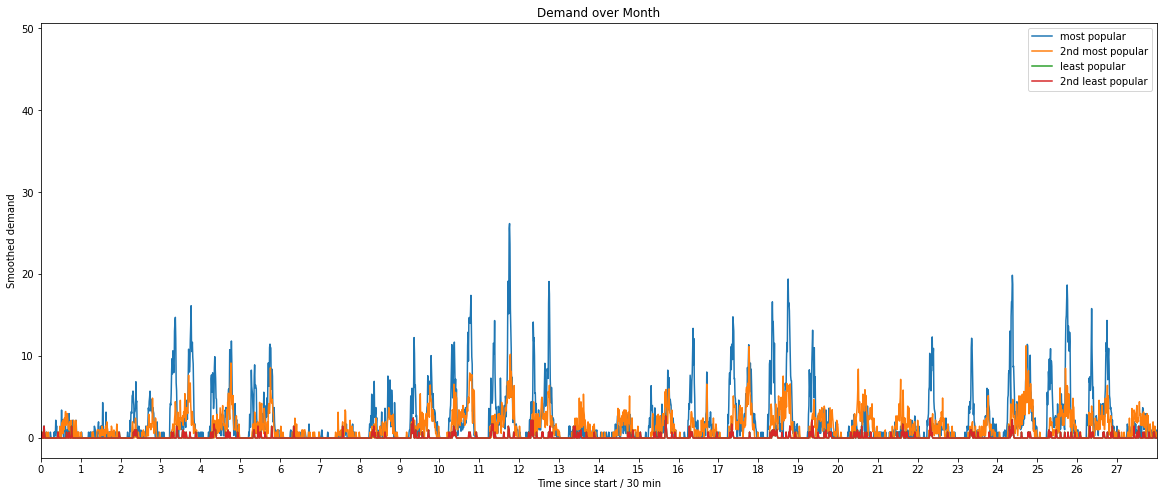

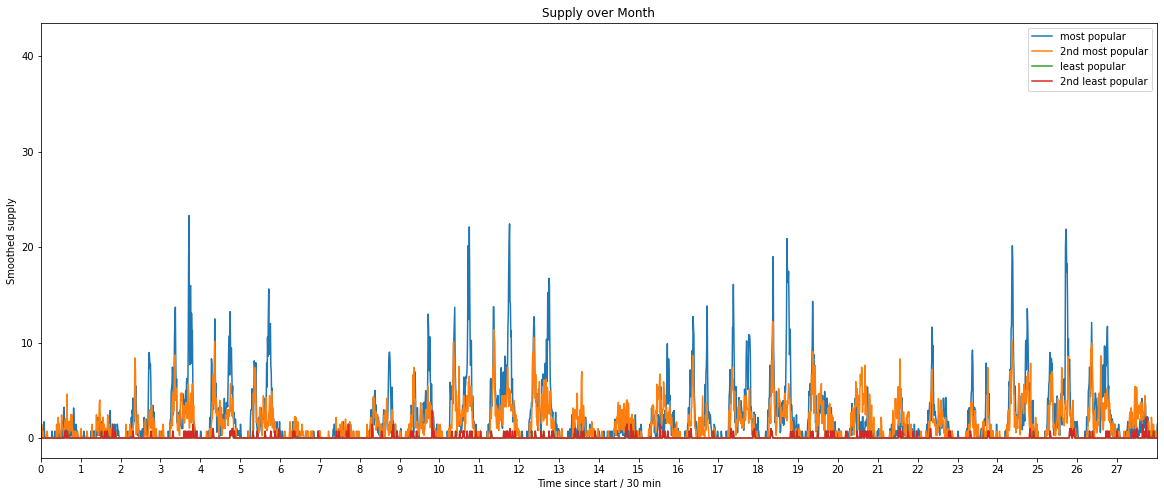

In [4]:
dt, units = 15, 'm'
hourbydt = 60/dt

smoothing_type = 'gaussian'
var = 1
smoothing_window = 5

END_REF_TIME = all_df['stop_time'].max()
end_time = (END_REF_TIME - START_REF_TIME)//np.timedelta64(dt,units)

stations_to_plot = [popular_stations[0],popular_stations[1],popular_stations[-1],popular_stations[-1]]
labels = ['most popular', '2nd most popular', 'least popular', '2nd least popular']

plt.figure(figsize=(20,8))

plt.ylabel("Smoothed demand")
plt.xlabel("Time since start / 30 min")

plt.title("Demand over Month")
plt.xlim(0, 4 * 24 * 7 * hourbydt)
plt.xticks(ticks=[i * hourbydt * 24 for i in range(4*7)],labels=[str(i) for i in range(4*7)])

for i, station in enumerate(stations_to_plot):

    time_series = all_df[all_df['start_id']==station].sort_values(by='start_time')['start_time']
    time_series = (time_series - START_REF_TIME)//np.timedelta64(dt,units)

    times, counts = np.unique(time_series, return_counts=True)
    times, counts = get_filled_series(times,counts,start_time=0,end_time=end_time)
    
    plt.plot(times,smooth_counts(counts,filter_size=smoothing_window,filter_type=smoothing_type,var=var),label=labels[i])
plt.legend()


plt.figure(figsize=(20,8))

plt.ylabel("Smoothed supply")
plt.xlabel("Time since start / 30 min")

plt.title("Supply over Month")
plt.xlim(0, 4 * 24 * 7 * hourbydt)
plt.xticks(ticks=[i * hourbydt * 24 for i in range(4*7)],labels=[str(i) for i in range(4*7)])

for i, station in enumerate(stations_to_plot):

    time_series = all_df[all_df['end_id']==station].sort_values(by='stop_time')['stop_time']
    time_series = (time_series - START_REF_TIME)//np.timedelta64(dt,units)

    times, counts = np.unique(time_series, return_counts=True)
    times, counts = get_filled_series(times,counts,start_time=0,end_time=end_time)
    
    plt.plot(times,smooth_counts(counts,filter_size=smoothing_window,filter_type=smoothing_type,var=var),label=labels[i])
plt.legend()

In [6]:
save = True
X_demand = []
X_supply = []

for station in popular_stations:

    time_series = all_df[all_df['start_id']==station].sort_values(by='start_time')['start_time']
    time_series = (time_series - START_REF_TIME)//np.timedelta64(dt,units)

    times, counts = np.unique(time_series, return_counts=True)
    times, counts = get_filled_series(times,counts,start_time=0,end_time=end_time)
    
    X_demand.append(counts)

for station in popular_stations:

    time_series = all_df[all_df['end_id']==station].sort_values(by='stop_time')['stop_time']
    time_series = (time_series - START_REF_TIME)//np.timedelta64(dt,units)

    times, counts = np.unique(time_series, return_counts=True)
    times, counts = get_filled_series(times,counts,start_time=0,end_time=end_time)
    
    X_supply.append(counts)
    

X_demand = np.array(X_demand) 
X_supply = np.array(X_supply)
time = np.arange(X_demand.shape[1])
time = np.tile(time,(X_demand.shape[0],1))
X = np.dstack([X_demand,X_supply,time])

In [7]:
if save:
    np.save(f'./X_top{top_n_stations}_{years[0]}{months[0]:02d}_{years[-1]}{months[-1]:02d}_{dt:02d}_{units}.npy', X)